In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
from src.pre_process.feature_add import FeatureAddition
from src.pre_process.feature_duplicate import FeatureDuplication

In [3]:
BASE_PATH = r'C:\Users\USER\OneDrive\문서\GitHub\level2-competitiveds-recsys-06\data\processed'
data = pd.read_csv(os.path.join(BASE_PATH, 'v7_infra_score.csv'))
# train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
# test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
# sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

In [4]:
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

---

In [5]:
data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,nearest_park_within_500.0m,has_park_within_500.0m,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,arima_deposit_index,infra_score
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,1,1,7683,29300,0,NaN,1.78,-0.07,102.180354,1.048401
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,1,1,7683,29300,1,17000.0,1.26,-0.17,105.586089,1.048401
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,1,1,7683,29300,2,23000.0,1.26,-0.17,105.586089,1.048401
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,3,1,18366,58901,3,NaN,1.68,-0.10,103.855832,0.650367
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,1,1,18369,58863,4,NaN,1.85,-0.09,100.000000,0.031857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,...,1,1,6088,25360,150167,37000.0,3.62,-0.04,142.092659,1.068428
1951396,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,...,1,1,6088,17911,150168,43000.0,3.59,-0.03,142.295862,1.068428
1951397,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,...,1,1,6088,17911,150169,43000.0,3.59,-0.03,142.295862,1.068428
1951398,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,...,1,1,6088,24128,150170,32500.0,3.59,-0.03,142.295862,1.068428


In [6]:
data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit', '_type', 'apt_idx', 'area', 'area_price', 'area_m2_price',
       'grid_id', 'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate',

---

# 추가 EDA

In [7]:
# contract_type one-hot encoding
data = pd.get_dummies(data, columns=['contract_type'], prefix='contract')

In [8]:
data.drop(columns='contract_2', inplace=True)

In [9]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,arima_deposit_index,infra_score,contract_0,contract_1
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,7683,29300,0,NaN,1.78,-0.07,102.180354,1.048401,False,False
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,7683,29300,1,17000.0,1.26,-0.17,105.586089,1.048401,False,False
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,7683,29300,2,23000.0,1.26,-0.17,105.586089,1.048401,False,False
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,18366,58901,3,NaN,1.68,-0.10,103.855832,0.650367,False,False
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,18369,58863,4,NaN,1.85,-0.09,100.000000,0.031857,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,6088,25360,150167,37000.0,3.62,-0.04,142.092659,1.068428,True,False
1951396,150168,142.8738,202403,2,4,2010,37.528394,126.659398,14,NaN,...,6088,17911,150168,43000.0,3.59,-0.03,142.295862,1.068428,True,False
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,6088,17911,150169,43000.0,3.59,-0.03,142.295862,1.068428,False,True
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,6088,24128,150170,32500.0,3.59,-0.03,142.295862,1.068428,False,True


In [82]:
data['contract_year_month'] = data['contract_year_month'].astype(str)

# 'contract_day'를 두 자리로 맞추기 위한 처리
data['contract_day'] = data['contract_day'].apply(lambda x: f"{x:02d}")

# 날짜 형식으로 결합
data['contract_date'] = pd.to_datetime(data['contract_year_month'] + data['contract_day'], format='%Y%m%d')

In [83]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,has_park_within_500.0m,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,1,7683,29300,0,NaN,1.78,-0.07,False,False,2019-06-25
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,1,7683,29300,1,17000.0,1.26,-0.17,False,False,2020-03-26
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,1,7683,29300,2,23000.0,1.26,-0.17,False,False,2020-03-28
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,1,18366,58901,3,NaN,1.68,-0.10,False,False,2019-07-15
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,1,18369,58863,4,NaN,1.85,-0.09,False,False,2019-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,1,6088,25360,150167,37000.0,3.62,-0.04,True,False,2024-02-27
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,1,6088,17911,150168,43000.0,3.59,-0.03,True,False,2024-03-02
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,1,6088,17911,150169,43000.0,3.59,-0.03,False,True,2024-03-16
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,1,6088,24128,150170,32500.0,3.59,-0.03,False,True,2024-03-22


In [84]:
data['contract_date_numeric'] = data['contract_date'].dt.strftime('%Y%m%d').astype(int)

In [85]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date,contract_date_numeric
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,7683,29300,0,NaN,1.78,-0.07,False,False,2019-06-25,20190625
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,7683,29300,1,17000.0,1.26,-0.17,False,False,2020-03-26,20200326
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,7683,29300,2,23000.0,1.26,-0.17,False,False,2020-03-28,20200328
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,18366,58901,3,NaN,1.68,-0.10,False,False,2019-07-15,20190715
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,18369,58863,4,NaN,1.85,-0.09,False,False,2019-04-12,20190412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,6088,25360,150167,37000.0,3.62,-0.04,True,False,2024-02-27,20240227
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,6088,17911,150168,43000.0,3.59,-0.03,True,False,2024-03-02,20240302
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,6088,17911,150169,43000.0,3.59,-0.03,False,True,2024-03-16,20240316
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,6088,24128,150170,32500.0,3.59,-0.03,False,True,2024-03-22,20240322


In [86]:
data.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day', 'floor',
       'built_year', 'latitude', 'longitude', 'age', 'deposit', '_type',
       'apt_idx', 'area', 'area_price', 'area_m2_price', 'grid_id',
       'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate', 'contract_0',
  

In [103]:
data[(data['age'] < 0) & (data['_type'] == 'test')]

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,apt_deposit_rank,apt_area_deposit_rank,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date,contract_date_numeric


In [115]:
data = pd.get_dummies(data, columns=['category_interchange_within_1km'], prefix='interchange')

In [117]:
data.drop(columns=['interchange_0', 'interchange_1'], inplace=True)

In [144]:
data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,original_index,recent_deposit,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date,contract_date_numeric,interchange_2,apt_floor_deposit_rank
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,0,NaN,1.78,-0.07,False,False,2019-06-25,20190625,False,97941
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,1,17000.0,1.26,-0.17,False,False,2020-03-26,20200326,False,113270
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,2,23000.0,1.26,-0.17,False,False,2020-03-28,20200328,False,100261
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,3,NaN,1.68,-0.10,False,False,2019-07-15,20190715,False,191078
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,4,NaN,1.85,-0.09,False,False,2019-04-12,20190412,False,192552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,150167,37000.0,3.62,-0.04,True,False,2024-02-27,20240227,False,77448
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,150168,43000.0,3.59,-0.03,True,False,2024-03-02,20240302,False,60621
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,150169,43000.0,3.59,-0.03,False,True,2024-03-16,20240316,False,85567
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,150170,32500.0,3.59,-0.03,False,True,2024-03-22,20240322,False,75423


In [133]:
grouped_floor_df = (
    data.groupby(["latitude", "longitude", "floor"])["deposit"]
    .agg(["mean", "count"])
    .reset_index()
)
# 전체 deposit의 평균 계산 (NaN 제외)
overall_mean = data["deposit"].mean()
# NaN 그룹 처리: deposit이 모두 NaN인 그룹의 평균을 전체 평균으로 설정
grouped_floor_df["mean"] = grouped_floor_df["mean"].fillna(overall_mean)
# mean을 기준으로 정렬
grouped_floor_df = grouped_floor_df.sort_values(by="mean", ascending=False)
# apt_area_deposit_rank 부여
grouped_floor_df["apt_floor_deposit_rank"] = range(1, len(grouped_floor_df) + 1)
# 원래 데이터프레임에 apt_area_deposit_rank 병합
data = data.merge(
    grouped_floor_df[
        ["latitude", "longitude", "floor", "apt_floor_deposit_rank"]
    ],
    on=["latitude", "longitude", "floor"],
    how="left",
)

In [135]:
data['apt_floor_deposit_rank'].max()

np.int64(192636)

In [147]:
grouped_age_df = (
    data.groupby(["latitude", "longitude", "age"])["deposit"]
    .agg(["mean", "count"])
    .reset_index()
)
# 전체 deposit의 평균 계산 (NaN 제외)
overall_mean = data["deposit"].mean()
# NaN 그룹 처리: deposit이 모두 NaN인 그룹의 평균을 전체 평균으로 설정
grouped_age_df["mean"] = grouped_floor_df["mean"].fillna(overall_mean)
# mean을 기준으로 정렬
grouped_age_df = grouped_age_df.sort_values(by="mean", ascending=False)
# apt_area_deposit_rank 부여
grouped_age_df["apt_age_deposit_rank"] = range(1, len(grouped_age_df) + 1)
# 원래 데이터프레임에 apt_area_deposit_rank 병합
data = data.merge(
    grouped_age_df[
        ["latitude", "longitude", "age", "apt_age_deposit_rank"]
    ],
    on=["latitude", "longitude", "age"],
    how="left",
)

In [148]:
data['apt_age_deposit_rank'].max()

np.int64(84936)

---

In [10]:
train_data = data[data['_type'] == 'train']
test_data = data[data['_type'] == 'test']

In [11]:
column_needed = [
    # 'index', 
    'area_m2', 'floor', 'age', 'latitude', 'longitude', 'apt_idx', 'nearest_subway_distance',
    'category_interchange_within_1km',
    'deposit',
    # '_type', 
    'grid_id', 'apt_deposit_rank', 'apt_area_deposit_rank', 'recent_deposit',
    'contract_year_month', 'contract_0', 'contract_1', 'infra_score'
]
test_column_needed = [
    # 'index', 
    'area_m2', 'floor', 'age', 'latitude', 'longitude', 'apt_idx', 'nearest_subway_distance',
    'category_interchange_within_1km',
    # 'deposit',
    # '_type', 
    'grid_id', 'apt_deposit_rank', 'apt_area_deposit_rank', 'recent_deposit',
    'contract_year_month', 'contract_0', 'contract_1', 'infra_score'
]
train_df = train_data[column_needed]
test_df = test_data[test_column_needed]

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# # 학습에 사용할 특징 열
# feature_columns = [col for col in data.columns if col not in ['deposit', '_type', 'index']]
# 학습 및 테스트 데이터 준비
X_train = train_df.drop(columns=['deposit'])
y_train = train_df['deposit']
X_test = test_df.copy()
# 학습 데이터를 검증용으로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2,
                                                                          random_state=42)
# XGBoost를 위한 DMatrix 생성
dtrain = xgb.DMatrix(X_train_split, label=y_train_split)
dval = xgb.DMatrix(X_val_split, label=y_val_split)
dtest = xgb.DMatrix(X_test)
# XGBoost 파라미터 설정
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
# 모델 학습
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=50, evals=evals, verbose_eval=10)
# 테스트 세트에 대한 예측
y_pred = model.predict(dtest)

[0]	train-mae:16479.86185	eval-mae:16481.87048
[10]	train-mae:11197.12924	eval-mae:11201.14040
[20]	train-mae:8030.20398	eval-mae:8029.13298
[30]	train-mae:6247.39000	eval-mae:6240.92884
[40]	train-mae:5248.09441	eval-mae:5238.56284
[50]	train-mae:4745.68682	eval-mae:4735.50677
[60]	train-mae:4499.18406	eval-mae:4491.39225
[70]	train-mae:4351.47758	eval-mae:4345.88767
[80]	train-mae:4263.41044	eval-mae:4259.45023
[90]	train-mae:4224.35372	eval-mae:4221.53825
[100]	train-mae:4193.32294	eval-mae:4191.10950
[110]	train-mae:4171.39587	eval-mae:4169.96910
[120]	train-mae:4149.93517	eval-mae:4148.93791
[130]	train-mae:4128.88873	eval-mae:4128.61671
[140]	train-mae:4113.73918	eval-mae:4114.26981
[150]	train-mae:4099.11580	eval-mae:4100.15481
[160]	train-mae:4082.29243	eval-mae:4083.90335
[170]	train-mae:4069.55454	eval-mae:4071.83227
[180]	train-mae:4056.96395	eval-mae:4059.98750
[190]	train-mae:4046.63873	eval-mae:4050.33946
[200]	train-mae:4036.88481	eval-mae:4041.21256
[210]	train-mae:4031

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

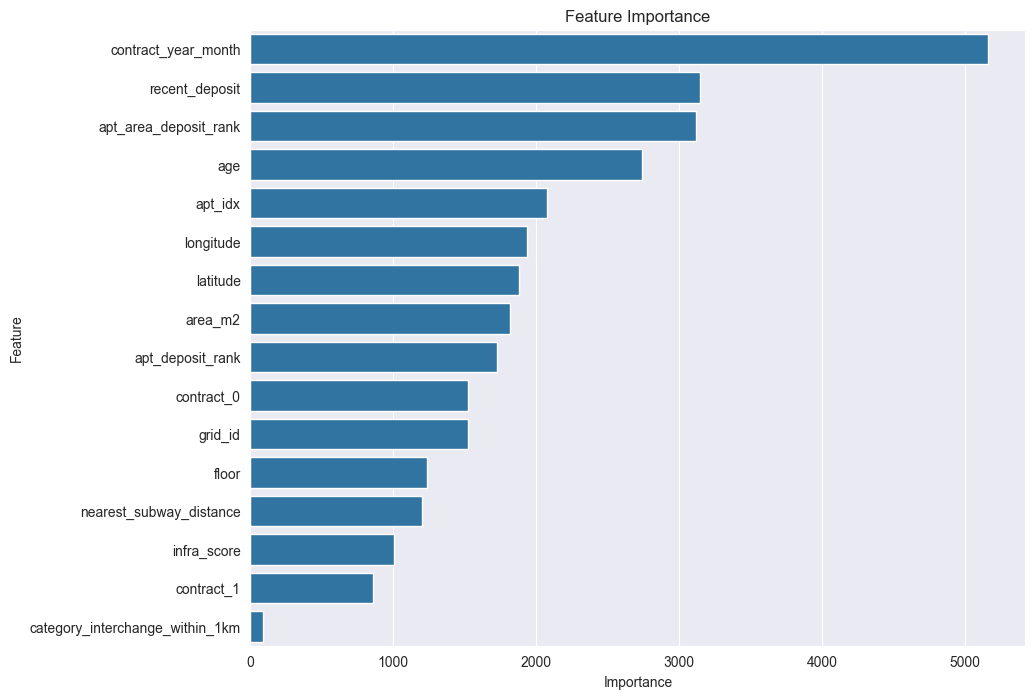

In [15]:
#Feature Importance
# 피처 중요도 추출
feature_importance = model.get_fscore()
# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])
# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [16]:
y_pred

array([22694.76 ,  7619.729,  6582.613, ..., 44618.684, 36514.78 ,
       37667.895], dtype=float32)

In [17]:
sample_submission['deposit'] = y_pred
sample_submission

,index,deposit
0,0,22694.759766
1,1,7619.729004
2,2,6582.612793
3,3,6812.312988
4,4,6850.925781
...,...,...
150167,150167,37163.253906
150168,150168,43478.726562
150169,150169,44618.683594
150170,150170,36514.781250


In [18]:
sample_submission.describe()

,index,deposit
count,150172.00000,150172.000000
mean,75085.50000,39092.089844
std,43351.06665,23881.607422
min,0.00000,3231.448730
25%,37542.75000,23162.708984
50%,75085.50000,33823.345703
75%,112628.25000,48531.857422
max,150171.00000,319986.000000


In [19]:
sample_submission.to_csv('v7_xgboost.csv', index=False)

---

In [181]:
dt = xgb.DMatrix(X_train)
x_pred = model.predict(dt)

In [182]:
x_pred.mean()

np.float32(38021.207)

In [183]:
train_data['deposit_xgb'] = x_pred
test_data['deposit_xgb'] = y_pred

C:\Users\USER\AppData\Local\Temp\ipykernel_6332\167302861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['deposit_xgb'] = x_pred
C:\Users\USER\AppData\Local\Temp\ipykernel_6332\167302861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['deposit_xgb'] = y_pred


In [63]:
train_data.drop(columns=['deposit_xgboost'], inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_6332\4262335724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns=['deposit_xgboost'], inplace=True)


In [184]:
train_data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date,contract_date_numeric,interchange_2,apt_floor_deposit_rank,apt_age_deposit_rank,deposit_xgb
0,0,84.9981,201906,25,9,2019,37.054314,127.045216,0,17000.0,...,1.78,-0.07,False,False,2019-06-25,20190625,False,97941,68180,25370.437500
1,1,84.9981,202003,26,20,2019,37.054314,127.045216,1,23000.0,...,1.26,-0.17,False,False,2020-03-26,20200326,False,113270,45336,25423.611328
2,2,84.9981,202003,28,8,2019,37.054314,127.045216,1,23000.0,...,1.26,-0.17,False,False,2020-03-28,20200328,False,100261,45336,26568.945312
3,3,59.3400,201907,15,1,1986,36.964647,127.055847,33,5000.0,...,1.68,-0.10,False,False,2019-07-15,20190715,False,191078,83873,3870.588135
4,4,59.8100,201904,12,6,1995,36.972390,127.084514,24,1800.0,...,1.85,-0.09,False,False,2019-04-12,20190412,False,192552,84882,3102.130127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,5,2010,37.528394,126.659398,13,39000.0,...,4.00,0.03,True,False,2023-11-25,20231125,False,89159,41273,34872.437500
1801224,1801224,101.9088,202311,28,6,2010,37.528394,126.659398,13,38000.0,...,4.00,0.03,True,False,2023-11-28,20231128,False,82542,41273,35268.730469
1801225,1801225,114.7900,202312,03,19,2010,37.528394,126.659398,13,37000.0,...,3.84,-0.16,True,False,2023-12-03,20231203,False,56452,41273,34787.164062
1801226,1801226,101.9088,202312,04,15,2010,37.528394,126.659398,13,34400.0,...,3.84,-0.16,False,True,2023-12-04,20231204,False,77673,41273,37370.910156


In [185]:
test_data

,index,area_m2,contract_year_month,contract_day,floor,built_year,latitude,longitude,age,deposit,...,interest_rate,diff_interest_rate,contract_0,contract_1,contract_date,contract_date_numeric,interchange_2,apt_floor_deposit_rank,apt_age_deposit_rank,deposit_xgb
1801228,0,84.9610,202404,12,14,2016,36.965423,127.048779,8,NaN,...,3.54,-0.05,False,True,2024-04-12,20240412,False,152134,26098,22055.064453
1801229,1,59.9000,202404,13,4,1997,36.963105,127.040678,27,NaN,...,3.54,-0.05,True,False,2024-04-13,20240413,False,189676,25913,7631.298340
1801230,2,39.2700,202404,29,5,1990,36.957089,127.047449,34,NaN,...,3.54,-0.05,True,False,2024-04-29,20240429,False,190974,25529,6959.377441
1801231,3,39.2700,202405,03,1,1990,36.957089,127.047449,34,NaN,...,3.56,0.02,True,False,2024-05-03,20240503,False,191242,25529,6970.602539
1801232,4,46.9800,202406,02,4,1990,36.957089,127.047449,34,NaN,...,3.56,0.00,True,False,2024-06-02,20240602,False,191607,25529,7039.619141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,115.5101,202402,27,17,2010,37.528394,126.659398,14,NaN,...,3.62,-0.04,True,False,2024-02-27,20240227,False,77448,26467,37629.339844
1951396,150168,142.8738,202403,02,4,2010,37.528394,126.659398,14,NaN,...,3.59,-0.03,True,False,2024-03-02,20240302,False,60621,26467,45417.039062
1951397,150169,142.8738,202403,16,13,2010,37.528394,126.659398,14,NaN,...,3.59,-0.03,False,True,2024-03-16,20240316,False,85567,26467,43753.320312
1951398,150170,114.9285,202403,22,2,2010,37.528394,126.659398,14,NaN,...,3.59,-0.03,False,True,2024-03-22,20240322,False,75423,26467,37024.882812


In [186]:
column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index', 'contract_type','contract_year_month', 'contract_day',
    'area_m2', 'contract_date_numeric',
    'floor', 'built_year', 'latitude', 'longitude', 'age',
    'contract_0', 'contract_1',
    'deposit',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    # 'num_subway_within_1km',
    # 'category_interchange_within_1km',
    # 'num_subway_within_500m', 
    # 'category_interchange_within_500m',
    'nearest_elementary_school_distance',
    # 'nearest_elementary_school_within_1km',
    # 'has_elementary_school_within_1km',
    'nearest_middle_school_distance',
    # 'nearest_middle_school_within_1km',
    # 'has_middle_school_within_1km',
    'nearest_high_school_distance',
    # 'nearest_high_school_within_1km',
    # 'has_high_school_within_1km',
    'nearest_park_distance',
    # 'nearest_park_within_500.0m',
    # 'has_park_within_500.0m',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit',
    'interchange_2',
    'apt_floor_deposit_rank',
    'deposit_xgb',
    # 'apt_age_deposit_rank',
    # 'interest_rate', 
    # 'diff_interest_rate',
]
test_column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index','deposit', 'contract_type','contract_year_month', 'contract_day',
    'area_m2', 'contract_date_numeric',
    'floor', 'built_year', 'latitude', 'longitude', 'age',
    'contract_0', 'contract_1',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    # 'num_subway_within_1km',
    # 'category_interchange_within_1km',
    # 'num_subway_within_500m', 
    # 'category_interchange_within_500m',
    'nearest_elementary_school_distance',
    # 'nearest_elementary_school_within_1km',
    # 'has_elementary_school_within_1km',
    'nearest_middle_school_distance',
    # 'nearest_middle_school_within_1km',
    # 'has_middle_school_within_1km',
    'nearest_high_school_distance',
    # 'nearest_high_school_within_1km',
    # 'has_high_school_within_1km',
    'nearest_park_distance',
    # 'nearest_park_within_500.0m',
    # 'has_park_within_500.0m',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit',
    'interchange_2',
    'apt_floor_deposit_rank',
    'deposit_xgb',
    # 'apt_age_deposit_rank',
    # 'interest_rate', 
    # 'diff_interest_rate',
]
train_df = train_data[column_needed]
test_df = test_data[test_column_needed]

In [187]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# # 학습에 사용할 특징 열
# feature_columns = [col for col in data.columns if col not in ['deposit', '_type', 'index']]
# 학습 및 테스트 데이터 준비
X_train = train_df.drop(columns=['deposit'])
y_train = train_df['deposit']
X_test = test_df.copy()
# 학습 데이터를 검증용으로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2,
                                                                          random_state=42)
# XGBoost를 위한 DMatrix 생성
dtrain = xgb.DMatrix(X_train_split, label=y_train_split)
dval = xgb.DMatrix(X_val_split, label=y_val_split)
dtest = xgb.DMatrix(X_test)
# XGBoost 파라미터 설정
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
# 모델 학습
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=50, evals=evals, verbose_eval=10)
# 테스트 세트에 대한 예측
y_pred = model.predict(dtest)

[0]	train-mae:16464.45676	eval-mae:16466.07340
[10]	train-mae:11049.62328	eval-mae:11058.20231
[20]	train-mae:7731.46794	eval-mae:7737.13333
[30]	train-mae:5796.51293	eval-mae:5800.03398
[40]	train-mae:4781.13547	eval-mae:4786.16698
[50]	train-mae:4270.39265	eval-mae:4278.62314
[60]	train-mae:4030.07894	eval-mae:4042.47469
[70]	train-mae:3924.71605	eval-mae:3939.80683
[80]	train-mae:3875.48258	eval-mae:3892.16999
[90]	train-mae:3849.64203	eval-mae:3867.70751
[100]	train-mae:3834.21065	eval-mae:3853.10997
[110]	train-mae:3822.96153	eval-mae:3842.37512
[120]	train-mae:3816.78772	eval-mae:3836.78335
[130]	train-mae:3812.36132	eval-mae:3832.63182
[140]	train-mae:3809.46010	eval-mae:3830.04614
[150]	train-mae:3805.78654	eval-mae:3826.75599
[160]	train-mae:3797.13756	eval-mae:3818.78944
[170]	train-mae:3787.78850	eval-mae:3810.06715
[180]	train-mae:3777.98387	eval-mae:3801.01272
[190]	train-mae:3771.29879	eval-mae:3795.46611
[200]	train-mae:3764.80359	eval-mae:3789.76068
[210]	train-mae:3759

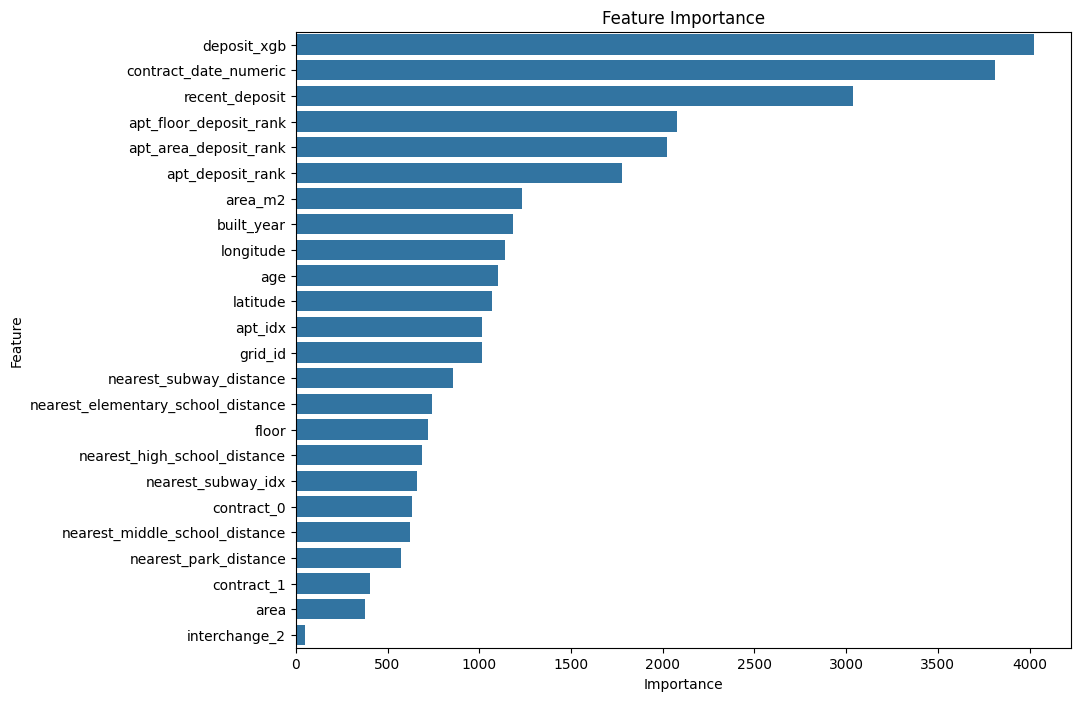

In [188]:
#Feature Importance
# 피처 중요도 추출
feature_importance = model.get_fscore()
# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])
# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [189]:
y_pred.mean()

np.float32(38970.883)

In [190]:
sample_submission['deposit'] = y_pred
sample_submission

,index,deposit
0,0,22538.445312
1,1,7690.486328
2,2,6733.950195
3,3,6708.965820
4,4,6764.403320
...,...,...
150167,150167,37089.187500
150168,150168,45151.945312
150169,150169,43809.570312
150170,150170,37277.171875


In [191]:
sample_submission.to_csv('v4_add(apt_floor_rank_deposit_xgboost).csv', index=False, encoding='utf-8-sig')